# Experiment of Latent graph signal recovery
by tianpei, Jan 30 2017

##  Network build and Node sample generation

In [1]:
import numpy as np
import scipy as sp
import mpl_toolkits.mplot3d.art3d as art3d
import matplotlib.pyplot as plt
import networkx as nx
from time import strftime, gmtime
#import graph_tool.all as gt
%matplotlib inline  

In [2]:
from latent_signal_network import latent_signal_network as lsn 

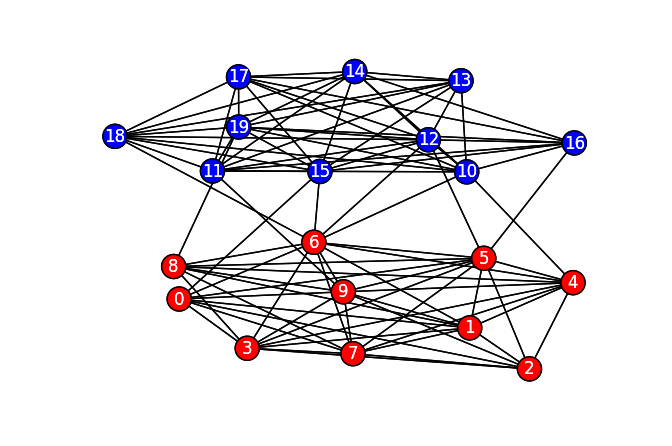

In [3]:
choice = 'partition'

if choice == 'newman':
    size = 20
    prob = 0
    seed = 1000
    d = 10
    option= {'seed': seed, 'node_dim': d, 'model': 'newman'}
    option['k-NN'] = 2
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option, save_fig=True)
elif choice == 'partition':
    size = [10, 10]
    prob = [0.9, 0.1]
    seed = 1000
    d = 10
    option= {'seed': seed, 'node_dim': d, 'model': 'partition'}
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option)
elif choice == 'grid':
    size = [4, 5]
    seed = 1000
    prob = 0.6
    d = 10
    option= {'seed': seed, 'node_dim': d, 'model': 'grid'}
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option)
elif choice == 'binomial':
    size = 20
    prob = 0.18
    seed = 1000
    d = 10
    option= {'seed': seed, 'node_dim': d, 'model': 'binomial'}
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option)

In [4]:
G0.node[G0.nodes()[0]]

{'attributes': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])}

In [5]:
Tmax = 10

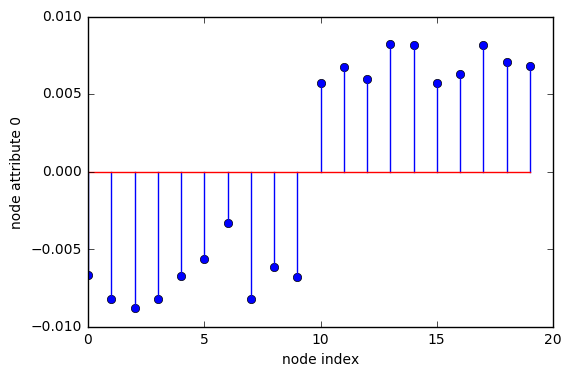

In [6]:
G0_node, X0, hist_tv = LSN.smooth_gsignal_generate(G0, T=Tmax, sigma=5)
plt.figure(1)
plt.stem(np.arange(X0.shape[0]),X0[:,1])
plt.xlabel('node index')
plt.ylabel('node attribute 0')
plt.show()

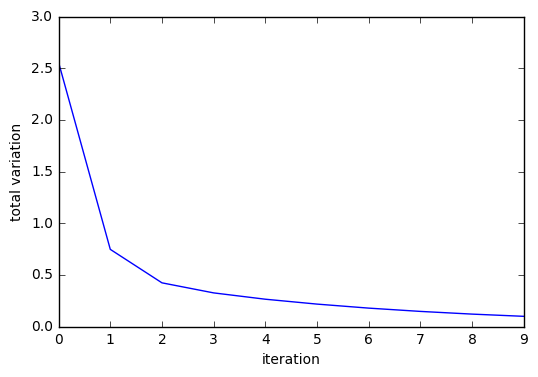

In [7]:
fig2 = plt.figure(2)
plt.plot(np.arange(Tmax), hist_tv, 'b')
plt.xlabel('iteration')
plt.ylabel('total variation')
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_tv.eps"
fig2.savefig(filename)

In [8]:
if choice != 'newman':
    pos=nx.nx_pydot.graphviz_layout(G0)
elif choice == 'newman':
    pos=nx.circular_layout(G0, dim=2, scale=1.0, center=None)
    
pos_coordinate = np.array([[pos[key][0], pos[key][1]] for key in pos])
X0, nodeIdx = LSN.get_node_attributes(G0)
edge_list = LSN.get_edgelist(G0)

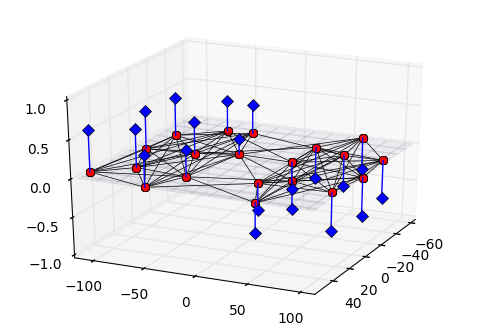

In [9]:
LSN.plot_node_3d(pos_coordinate, edge_list, X0, view_angle=[25,25], nodeIdx=nodeIdx)

In [10]:
tv = LSN.compute_total_variation(G0)
tv

0.098514612093383219